In [ ]:
!pip install tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [26]:
import tensorflow
from tensorflow import keras
from keras import utils
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import array_to_img
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Assuming paths are defined
info_path = '/content/drive/MyDrive/archive/Info.txt'
images_directory = '/content/drive/MyDrive/archive/all-mias'

info_df = pd.read_csv(info_path, sep='\s+', header=None, names=['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS'])

# Convert columns to the appropriate data types
info_df['X'] = pd.to_numeric(info_df['X'], errors='coerce')  # Convert X to numeric, making non-numeric values NaN
info_df['Y'] = pd.to_numeric(info_df['Y'], errors='coerce')
info_df['RADIUS'] = pd.to_numeric(info_df['RADIUS'], errors='coerce')

# Adjust the 'Y' coordinate if necessary, assuming origin is at top-left for image processing
info_df['Y'] = info_df['Y'].apply(lambda y: 1024 - y if pd.notnull(y) else y)

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def generate_patches(roi):
    angles = [90, 180, 270]
    patches = []

    for angle in angles:
        # Rotate ROI
        rotated = rotate_image(roi, angle)
        patches.append(rotated)

        # Flip rotated ROI
        flipped = cv2.flip(rotated, 1)
        patches.append(flipped)

    # Also include the original and its flipped version
    patches.append(roi)  # Original
    patches.append(cv2.flip(roi, 1))  # Flipped original

    return patches

def extract_and_augment_rois(row):
    image_path = os.path.join(images_directory, f'{row["REFNUM"]}.pgm')
    if not os.path.exists(image_path):
        print(f"Image {row['REFNUM']} not found.")
        return []

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if pd.notnull(row['X']) and pd.notnull(row['Y']) and pd.notnull(row['RADIUS']):
      x, y, radius = int(row['X']), int(row['Y']), int(row['RADIUS'])
      x, y, radius = max(radius, x), max(radius, y), min(1024 - max(x, y), radius)
      roi = image[y-radius:y+radius, x-radius:x+radius]
      roi_resized = cv2.resize(roi, (128, 128))
    else:
      roi_resized = cv2.resize(image, (128, 128))


    # Generate 8 patches: 3 rotations + original, each followed by its flipped version
    patches = generate_patches(roi_resized)

    class_dir = row['CLASS']
    if class_dir == "NORM":
      save_dir = os.path.join(augmented_data_dir, 'N')
    else:
      save_dir = os.path.join(augmented_data_dir, row['SEVERITY'])


    # Save each patch
    for patch_num, patch in enumerate(patches):
        patch_path = os.path.join(save_dir, f'{row["REFNUM"]}_{patch_num}.png')
        cv2.imwrite(patch_path, patch)


augmented_data_dir = '/content/drive/MyDrive/archive/Augmented_Data'
class_dirs = ['B', 'M', 'N']
for class_dir in class_dirs:
    class_path = os.path.join(augmented_data_dir, class_dir)
    if not os.path.exists(class_path):
        os.makedirs(class_path)

# Process each ROI and generate augmented patches
for index, row in info_df.iterrows():
  extract_and_augment_rois(row)


Image REFNUM not found.


In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, DepthwiseConv2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


model = Sequential()
# Input layer is implicitly defined by the input_shape argument in the first layer
model.add(Conv2D(32, (3, 3), input_shape=(48, 48, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Depth-wise Separable Convolutional Layers
model.add(DepthwiseConv2D(kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (1, 1), activation='relu'))  # Pointwise convolution
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Data preparation
train_data_dir = '/content/drive/MyDrive/archive/Augmented_Data'  # Update with your path
batch_size = 32

# This assumes subdirectories in 'augmented_data' are named 'B', 'M', and 'N'
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode='grayscale',  # If your images are grayscale
    class_mode='categorical',  # because we have multiple classes
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation')


# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//batch_size,
    epochs=30)  # Adjust the number of epochs based on your requirement



Found 2048 images belonging to 3 classes.
Found 510 images belonging to 3 classes.
Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.7466

In [39]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import numpy as np

test_data_dir = '/content/drive/MyDrive/archive/TestData'

# Assuming you have a test_generator similar to train_generator and validation_generator
test_generator = train_datagen.flow_from_directory(
    test_data_dir,  # Make sure to specify your test data directory
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False)  # Important: keep data in same order as labels

# Predicting the test dataset
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# For AUC, you need probability of positive class if binary, or use one-vs-all approach for multi-class
# This example is simplified for binary classification
# For multi-class, use roc_auc_score with average='macro' or 'weighted'
auc = roc_auc_score(y_true, predictions, multi_class="ovr")  # Adjust depending on your class index

# Calculating Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


# Print classification report for precision, recall, f1-score
print(classification_report(y_true, y_pred))

print(f"AUC: {auc}")



Found 26 images belonging to 3 classes.
1/1 [==============================] - 0s 339ms/step
[[13  0  0]
 [ 8  0  1]
 [ 0  0  4]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        13
           1       0.00      0.00      0.00         9
           2       0.80      1.00      0.89         4

    accuracy                           0.65        26
   macro avg       0.47      0.67      0.55        26
weighted avg       0.43      0.65      0.52        26

AUC: 0.8639568911062123


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
!pip install matplotlib seaborn scikit-plot

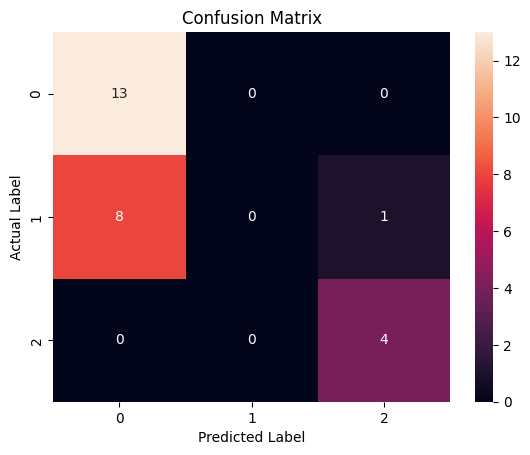

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import scikitplot as skplt

# Assuming y_true and y_pred are your true and predicted labels
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()



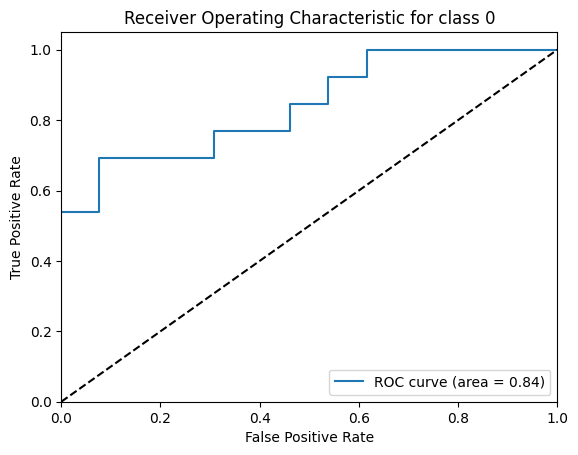

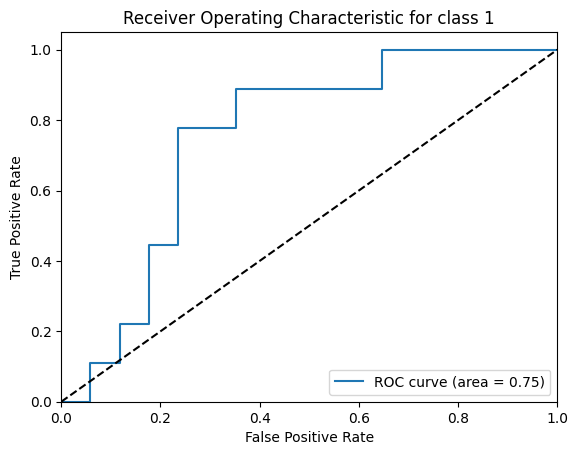

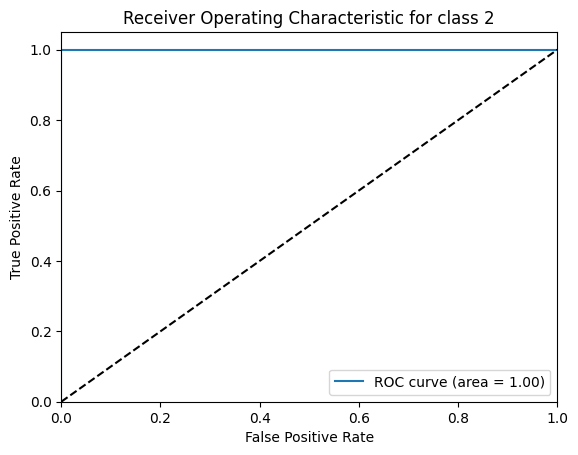

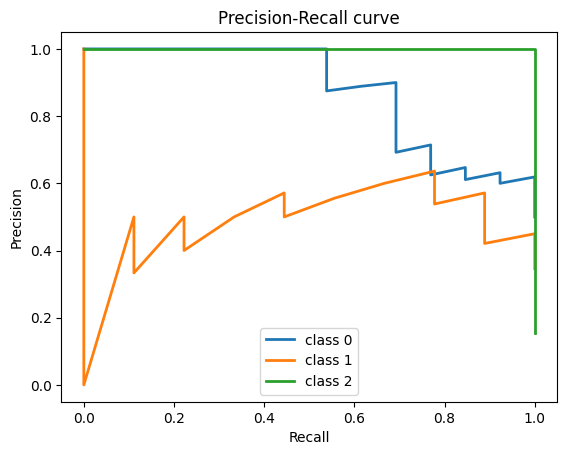

In [52]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np


# Binarize the labels for multi-class
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
y_score = predictions  # Assuming predictions contain probability scores for each class

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for class {i}')
    plt.legend(loc="lower right")
    plt.show()

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall curve")
plt.show()
